In [1]:
# https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from model.faster_rcnn_vgg16 import FasterRCNNVGG16
from utils.dataset import *
from utils import torch_utils
from utils.config import opt

In [2]:
torch.backends.cudnn.benchmark = True
np.random.seed(1)
torch.manual_seed(1)
torch.cuda.manual_seed(1)

In [3]:
# specify visible GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
device = torch_utils.select_device()

using CPU...


In [4]:
trainset = LoadDataset(opt.data_dir, opt.split);len(trainset)

5011

In [5]:
trainset[140][0].shape # 短边为600， 长边不固定

torch.Size([3, 600, 800])

shape:(600, 900, 3),dtype:uint8


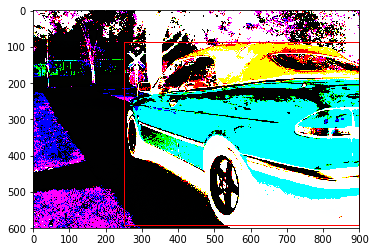

In [12]:
img = show_one_image(trainset[1][0], trainset[1][1])

In [6]:
img = trainset[140][0];img.shape

torch.Size([3, 600, 800])

In [7]:
gt = trainset[140][1];gt.shape

torch.Size([2, 4])

In [13]:
trainloader = DataLoader(trainset, batch_size=opt.batch_size, num_workers=opt.num_workers, shuffle=True)

In [7]:
faster_rcnn = FasterRCNNVGG16()

NameError: name 'load_kernel' is not defined

In [19]:
import numpy as np
# https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/rpn/generate_anchors.py
# Verify that we compute the same anchors as Shaoqing's matlab implementation:
#
#    >> load output/rpn_cachedir/faster_rcnn_VOC2007_ZF_stage1_rpn/anchors.mat
#    >> anchors
#
#    anchors =
#
#       -83   -39   100    56
#      -175   -87   192   104
#      -359  -183   376   200
#       -55   -55    72    72
#      -119  -119   136   136
#      -247  -247   264   264
#       -35   -79    52    96
#       -79  -167    96   184
#      -167  -343   184   360

#array([[ -83.,  -39.,  100.,   56.],
#       [-175.,  -87.,  192.,  104.],
#       [-359., -183.,  376.,  200.],
#       [ -55.,  -55.,   72.,   72.],
#       [-119., -119.,  136.,  136.],
#       [-247., -247.,  264.,  264.],
#       [ -35.,  -79.,   52.,   96.],
#       [ -79., -167.,   96.,  184.],
#       [-167., -343.,  184.,  360.]])

def generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """

    base_anchor = np.array([1, 1, base_size, base_size]) - 1 # [ 0  0 15 15]
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales)
                         for i in range(ratio_anchors.shape[0])])
    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """

    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr # 16 16 7.5 7.5

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """

    ws = ws[:, np.newaxis] # [23. 16. 11.].T
    hs = hs[:, np.newaxis] # [12. 16. 22.].T
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    """
    [[-3.5  2.  18.5 13. ]
     [ 0.   0.  15.  15. ]
     [ 2.5 -3.  12.5 18. ]]
    """
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    #anchor [ 0  0 15 15], ratios [0.5, 1, 2]
    w, h, x_ctr, y_ctr = _whctrs(anchor) # # 16 16 7.5 7.5
    size = w * h # 256
    size_ratios = size / ratios # [512. 256. 128.]
    ws = np.round(np.sqrt(size_ratios)) # [23. 16. 11.]
    hs = np.round(ws * ratios) # [12. 16. 22.]
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    """
    [[-3.5  2.  18.5 13. ]
     [ 0.   0.  15.  15. ]
     [ 2.5 -3.  12.5 18. ]]
    """
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """

    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

anchors = generate_anchors();anchors

In [84]:
anchors = generate_anchors();anchors

array([[ -84.,  -40.,   99.,   55.],
       [-176.,  -88.,  191.,  103.],
       [-360., -184.,  375.,  199.],
       [ -56.,  -56.,   71.,   71.],
       [-120., -120.,  135.,  135.],
       [-248., -248.,  263.,  263.],
       [ -36.,  -80.,   51.,   95.],
       [ -80., -168.,   95.,  183.],
       [-168., -344.,  183.,  359.]])

In [76]:
base_size = 16
ratios = [.5, 1, 2]
scales = [8, 16, 32]
base_anchor = np.array([1, 1, base_size, base_size]) - 1
anchors = []
w = base_anchor[2] - base_anchor[0] + 1
h = base_anchor[3] - base_anchor[1] + 1
x_ctr = base_anchor[0] + (w-1)/2
y_ctr = base_anchor[1] + (h-1)/2
size = w*h
for ratio in ratios:
    size_ratio = size/ratio
    ws = np.round(np.sqrt(size_ratio))
    hs = np.round(ws * ratio)
    anchor = np.hstack((x_ctr - 0.5 * (ws - 1),
                 y_ctr - 0.5 * (hs - 1),
                 x_ctr + 0.5 * (ws - 1),
                 y_ctr + 0.5 * (hs - 1)))
    for scale in scales:
        w = anchor[2] - anchor[0] + 1
        h = anchor[3] - anchor[1] + 1
        x_ctr = anchor[0] + (w-1)/2
        y_ctr = anchor[1] + (h-1)/2
        ws = w * scale
        hs = h * scale
        ranchor = np.hstack((x_ctr - 0.5 * (ws - 1),
                 y_ctr - 0.5 * (hs - 1),
                 x_ctr + 0.5 * (ws - 1),
                 y_ctr + 0.5 * (hs - 1)))
        anchors.append(ranchor)
np.vstack(anchors)

array([[ -84.,  -40.,   99.,   55.],
       [-176.,  -88.,  191.,  103.],
       [-360., -184.,  375.,  199.],
       [ -56.,  -56.,   71.,   71.],
       [-120., -120.,  135.,  135.],
       [-248., -248.,  263.,  263.],
       [ -36.,  -80.,   51.,   95.],
       [ -80., -168.,   95.,  183.],
       [-168., -344.,  183.,  359.]])

In [81]:
# https://github.com/rbgirshick/py-faster-rcnn/blob/master/lib/rpn/generate_anchors.py
def Generate_anchors(base_size=16, ratios=[0.5, 1, 2],
                     scales=[8, 16, 32]):
    base_anchor = np.array([1, 1, base_size, base_size]) - 1
    anchors = []
    w, h, x_ctr, y_ctr = whctrs(base_anchor) # 16 16 7.5 7.5
    size = w*h # 256
    for ratio in ratios:
        size_ratio = size/ratio # 512 256 128 
        ws = np.round(np.sqrt(size_ratio)) # 23 16 11
        hs = np.round(ws * ratio) # 12 16 22
        anchor = mkanchors(ws, hs, x_ctr, y_ctr)
        #print(anchor)
        for scale in scales:
            w, h, x_ctr, y_ctr = whctrs(anchor)
            ws = w * scale
            hs = h * scale
            ranchor = mkanchors(ws, hs, x_ctr, y_ctr)
            anchors.append(ranchor)
    return np.vstack(anchors)

In [78]:
def whctrs(anchor):
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr # 16 16 7.5 7.5

In [79]:
def mkanchors(ws, hs, x_ctr, y_ctr):

    anchor = np.hstack((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    return anchor

In [80]:
print(Generate_anchors())

[[ -84.  -40.   99.   55.]
 [-176.  -88.  191.  103.]
 [-360. -184.  375.  199.]
 [ -56.  -56.   71.   71.]
 [-120. -120.  135.  135.]
 [-248. -248.  263.  263.]
 [ -36.  -80.   51.   95.]
 [ -80. -168.   95.  183.]
 [-168. -344.  183.  359.]]
